# The CRISP-DM Data-Science Process for Personal Finance

CRISP-DM stands for Cross Industry Standard Process for Data Mining and describes the six phases in a data mining project.

- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results

Part 1:

Wanted to use some basic fundamental and technical indicators to help decision making in investing.

1. What companies share price have long-term positive momentum ?
2. What companies have the best balance sheet?
3. What does the chart show?

Part 2: 

Machine Learning (ML) stock price predictor at the bottom of this notebook.

## Business and Data Understanding

90% of investors fail in the market (stat from quora). This is because large firms can buy order-flow from brokers, so traditional methods like the one I use here are perhaps outdated. Ultimately, data analysis is used to profile retail investors and analyze where people put their money. 

For this project I use the unofficial Finviz and Yahoo Finance API's to gather the data I'm interested in.

## Library Imports

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from finviz.screener import Screener
from datetime import datetime
from finviz.helper_functions.request_functions import http_request_get
from finviz.helper_functions.scraper_functions import get_table
import nest_asyncio
import seaborn as sns
import timeit
# for LSTM:
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# libraries for language processing and ML 
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer # different from nltk.stem.wordnet ?
from nltk.corpus import stopwords
import pickle
import re

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## Finviz Screener API

Following three cells is code from https://github.com/mariostoev/finviz/blob/master/finviz/screener.py to get the list of values to screen companies. Parsing html is done with boutifulsoup4. Gets html from main filter page, ft=4 ensures all filters are present.

In [4]:
# Following three cells -> Code from https://github.com/mariostoev/finviz/blob/master/finviz/screener.py
# Parsing html with boutifulsoup4
# Get html from main filter page, ft=4 ensures all filters are present
hdr = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) "
    "Chrome/23.0.1271.64 Safari/537.11"
}
base_url = "https://finviz.com/screener.ashx" 
req = requests.get(base_url+"?ft=4", headers=hdr) 

In [5]:
html = req.text
# Parse html and locate table we are interested in.
# Use one of the text values and get the parent table from that
bs = BeautifulSoup(html, "html.parser")
filters_table = None
for td in bs.find_all("td"):
    if td.get_text().strip() == "Exchange":
        filters_table = td.find_parent("table")
if filters_table is None:
    raise Exception("Could not locate filter parameters")

In [6]:
 # Delete all div tags, we don't need them
for div in filters_table.find_all("div"):
    div.decompose()

# Populate dict with filtering options and corresponding filter tags
filter_dict = {}
td_list = filters_table.find_all("td")
for i in range(0, len(td_list) - 2, 2):
    current_dict = {}
    if td_list[i].get_text().strip() == "":
        continue

    # Even td elements contain filter name (as shown on web page)
    filter_text = td_list[i].get_text().strip()

    # Odd td elements contain the filter tag and options
    selections = td_list[i + 1].find("select")
    filter_name = selections.get("data-filter").strip()

    # Store filter options for current filter
    options = selections.find_all("option", {"value": True})
    for opt in options:
        # Encoded filter string
        value = opt.get("value").strip()

        # String shown in pull-down menu
        text = opt.get_text()

        # Filter out unwanted items
        if value is None or "Elite" in text:
            continue

        # Make filter string and store in dict
        current_dict[text] = f"{filter_name}_{value}"

    # Store current filter dict
    filter_dict[filter_text] = current_dict

In [7]:
# To know what I can filter with:
filter_dict

{'Exchange': {'Any': 'exch_',
  'AMEX': 'exch_amex',
  'NASDAQ': 'exch_nasd',
  'NYSE': 'exch_nyse'},
 'Index': {'Any': 'idx_', 'S&P 500': 'idx_sp500', 'DJIA': 'idx_dji'},
 'Sector': {'Any': 'sec_',
  'Basic Materials': 'sec_basicmaterials',
  'Communication Services': 'sec_communicationservices',
  'Consumer Cyclical': 'sec_consumercyclical',
  'Consumer Defensive': 'sec_consumerdefensive',
  'Energy': 'sec_energy',
  'Financial': 'sec_financial',
  'Healthcare': 'sec_healthcare',
  'Industrials': 'sec_industrials',
  'Real Estate': 'sec_realestate',
  'Technology': 'sec_technology',
  'Utilities': 'sec_utilities'},
 'Industry': {'Any': 'ind_',
  'Stocks only (ex-Funds)': 'ind_stocksonly',
  'Exchange Traded Fund': 'ind_exchangetradedfund',
  'Advertising Agencies': 'ind_advertisingagencies',
  'Aerospace & Defense': 'ind_aerospacedefense',
  'Agricultural Inputs': 'ind_agriculturalinputs',
  'Airlines': 'ind_airlines',
  'Airports & Air Services': 'ind_airportsairservices',
  'Alumin

## Gather data (list of companies)

This is using the Finviz Screener() class with filters and collects list of dictionaries of basic information for filtered companies.

If not working check updates for python package, or github issues.

In [271]:
# Get list of symbols
nest_asyncio.apply()
# Many possible ways of filtering. i.e. high float and volume (more volume than float means all the shares for sale are changing hands quickly)
# float is the amount of stocks for sale, market cap includes assets being held
# old filter: country = canada, avg volume > 10000 (10M), optionable and shortable, price < 50
# I had sh_avgvol at 10000 (10M) for geo canada and it was working?
filter = ["geo_usa", "sh_avgvol_o1000", "sh_float_o5" "sh_opt_optionshort", "sh_curvol_o500", "fa_pe_profitable", "fa_roa_pos", "fa_roe_pos", "fa_curratio_high"] # , "fa_ltdebteq_low",
stock_list = Screener(filters=filter, order='volume')
print ("%s symbols listed.\n" % len(stock_list))

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.02it/s]

154 symbols listed.



In [272]:
# print the list of stocks retrieved
for stock in stock_list:
    print(stock['Ticker'])

OLLI
APD
ZWS
PALT
RSI
FSLR
SOL
CARG
GNTX
MWA
ZTS
CIEN
HCSG
IIVI
AKAM
ENPH
PCAR
EXEL
GOOGL
FOUR
ISRG
ANET
TER
DDD
TMO
LRCX
SHLX
MNST
CSGP
HYLN
SWKS
AVIR
FAST
SLQT
GRWG
MP
VRTX
XLNX
RPRX
ROKU
MARK
IRWD
MRVI
BTBT
INCY
FOXA
RMO
EW
TXN
NKE
ZM
ATVI
EBAY
SKLZ
AMAT
PINS
RIOT
FB
MU
NVDA


In [8]:
stock_list[0]

{'No.': '1',
 'Ticker': 'VQS',
 'Company': 'VIQ Solutions Inc.',
 'Sector': 'Technology',
 'Industry': 'Software - Application',
 'Country': 'Canada',
 'Market Cap': '69.05M',
 'P/E': '-',
 'Price': '2.19',
 'Change': '1.39%',
 'Volume': '6,125'}

In [9]:
stock_list[0]['Volume']

'6,125'

## Finviz main functions to get stock info, news, insider buys, crypto and analyst recommendations

The code in the following cell is from https://github.com/mariostoev/finviz and is not my own. Proper acknowledgements and thanks to the maintainers of this repository. I modified one line in get_stock to return a dataFrame instead of dictionary.

In [10]:
STOCK_URL = "https://finviz.com/quote.ashx"
NEWS_URL = "https://finviz.com/news.ashx"
CRYPTO_URL = "https://finviz.com/crypto_performance.ashx"
STOCK_PAGE = {}

def get_page(ticker):
    global STOCK_PAGE

    if ticker not in STOCK_PAGE:
        STOCK_PAGE[ticker], _ = http_request_get(
            url=STOCK_URL, payload={"t": ticker}, parse=True
        )


def get_stock(ticker):
    """
    Returns a pandas dataframe containing stock data.
    :param ticker: stock symbol
    :type ticker: str
    :return dataframe
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]

    title = page_parsed.cssselect('table[class="fullview-title"]')[0]
    keys = ["Ticker", "Company", "Sector", "Industry", "Country"]
    fields = [ticker]+[f.text_content() for f in title.cssselect('a[class="tab-link"]')]
    data = dict(zip(keys, fields))

    all_rows = [
        row.xpath("td//text()")
        for row in page_parsed.cssselect('tr[class="table-dark-row"]')
    ]

    for row in all_rows:
        for column in range(0, 11, 2):
            data[row[column]] = row[column + 1]

    return pd.DataFrame.from_dict(data, orient='index').transpose()


def get_news(ticker):
    """
    Returns a list of sets containing news headline and url
    :param ticker: stock symbol
    :return: list
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]
    rows = page_parsed.cssselect('table[id="news-table"]')[0].xpath('./tr[not(@id)]')

    results = []
    date = None
    for row in rows:
        raw_timestamp = row.xpath("./td")[0].xpath('text()')[0][0:-2]

        if len(raw_timestamp) > 8:
            parsed_timestamp = datetime.strptime(raw_timestamp, "%b-%d-%y %I:%M%p")
            date = parsed_timestamp.date()
        else:
            parsed_timestamp = datetime.strptime(raw_timestamp, "%I:%M%p").replace(
                year=date.year, month=date.month, day=date.day)

        results.append((
            parsed_timestamp.strftime("%Y-%m-%d %H:%M"),
            row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].xpath("text()")[0],
            row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].get("href"),
            row.xpath("./td")[1].cssselect('div[class="news-link-right"] span')[0].xpath("text()")[0][1:]
        ))

    return results

def get_insider(ticker):
    """
    Returns a list of dictionaries containing all recent insider transactions.
    :param ticker: stock symbol
    :return: list
    """

    get_page(ticker)
    page_parsed = STOCK_PAGE[ticker]
    table = page_parsed.cssselect('table[class="body-table"]')[0]
    headers = table[0].xpath("td//text()")
    data = [dict(zip(headers, row.xpath("td//text()"))) for row in table[1:]]

    return data

def get_all_news():
    """
    Returns a list of sets containing time, headline and url
    :return: list
    """

    page_parsed, _ = http_request_get(url=NEWS_URL, parse=True)
    all_dates = [
        row.text_content() for row in page_parsed.cssselect('td[class="nn-date"]')
    ]
    all_headlines = [
        row.text_content() for row in page_parsed.cssselect('a[class="nn-tab-link"]')
    ]
    all_links = [
        row.get("href") for row in page_parsed.cssselect('a[class="nn-tab-link"]')
    ]

    return list(zip(all_dates, all_headlines, all_links))


def get_crypto(pair):
    """
    :param pair: crypto pair
    :return: dictionary
    """

    page_parsed, _ = http_request_get(url=CRYPTO_URL, parse=True)
    page_html, _ = http_request_get(url=CRYPTO_URL, parse=False)
    crypto_headers = page_parsed.cssselect('tr[valign="middle"]')[0].xpath("td//text()")
    crypto_table_data = get_table(page_html, crypto_headers)

    return crypto_table_data[pair]


def get_analyst_price_targets(ticker, last_ratings=5):
    """
    Returns a list of dictionaries containing all analyst ratings and Price targets
     - if any of 'price_from' or 'price_to' are not available in the DATA, then those values are set to default 0
    :param ticker: stock symbol
    :param last_ratings: most recent ratings to pull
    :return: list
    """

    analyst_price_targets = []

    try:
        get_page(ticker)
        page_parsed = STOCK_PAGE[ticker]
        table = page_parsed.cssselect('table[class="fullview-ratings-outer"]')[0]

        for row in table:
            rating = row.xpath("td//text()")
            rating = [val.replace("→", "->").replace("$", "") for val in rating if val != '\n']
            rating[0] = datetime.strptime(rating[0], "%b-%d-%y").strftime("%Y-%m-%d")

            data = {
                "date":     rating[0],
                "category": rating[1],
                "analyst":  rating[2],
                "rating":   rating[3],
            }
            if len(rating) == 5:
                if "->" in rating[4]:
                    rating.extend(rating[4].replace(" ", "").split("->"))
                    del rating[4]
                    data["target_from"] = float(rating[4])
                    data["target_to"] = float(rating[5])
                else:
                    data["target"] = float(rating[4])

            analyst_price_targets.append(data)
    except Exception as e:
        # print("-> Exception: %s parsing analysts' ratings for ticker %s" % (str(e), ticker))
        pass

    return analyst_price_targets[:last_ratings]

In [17]:
#example
info = get_stock('tlry')
info

,Ticker,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,...,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
0,tlry,"Tilray, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,-,-,-1.61,2.10%,449.40M,...,Oct 07 BMO,-,18.73M,11.59,2.80,5.39%,-5.10%,-34.57%,"43,922,280",-0.60%


In [13]:
len(news)

180

## Yahoo Finance API (get share price history)

Create a ticker_history_dict of basic info of Open, Low, High, Close (OLHC) and volume in a DataFrame for each company symbol collected by Finviz previously.

In [11]:
# Everytime the yahoo finance page changes code needs to be updated if there's a bug
# Use "pip install yfinance --upgrade --no-cache-dir" and restart the notebook kernel
# Get symbols price history from yahoo finance (len(stock_list) API calls here)
# using timeit to see how long this takes
start = timeit.timeit()
ticker_history_dict = {}
for stock in stock_list:
    ticker_history_dict[stock['Ticker']] = yf.Ticker(stock['Ticker']).history(period = "max") 
end = timeit.timeit()
print(end - start)
ticker_history_dict.keys()

-0.001721500011626631


dict_keys(['VQS', 'NOA', 'MIST', 'PCOM', 'PDS', 'CIXX', 'DRTT', 'BRAG', 'IPA', 'LOOP', 'GP', 'TAC', 'ORLA', 'TMQ', 'CGAU', 'TIXT', 'ACHV', 'LGO', 'SII', 'MMX', 'PROF', 'MDVL', 'VEV', 'EMX', 'VS', 'NEWP', 'DTEA', 'RPTX', 'THTX', 'PYR', 'MTA', 'SWIR', 'GAU', 'FUSN', 'MEOH', 'EPIX', 'MERC', 'FTRP', 'LMNL', 'ATY', 'NMG', 'YVR', 'DPRO', 'TNK', 'SJR', 'HUGE', 'WKSP', 'HITI', 'RCI', 'RFP', 'ABST', 'ELYS', 'IMAX', 'GROY', 'FTS', 'IMO', 'CLS', 'IMV', 'ZYME', 'SA', 'MAG', 'GIL', 'GSS', 'OTEX', 'AAU', 'CAE', 'APT', 'TU', 'BEP', 'CRDL', 'APTO', 'GAME', 'TRX', 'UROY', 'BLU', 'PBA', 'PLG', 'VFF', 'MOGO', 'TRQ', 'SILV', 'SVM', 'OR', 'HBM', 'AXU', 'EGLX', 'SSRM', 'NG', 'PVG', 'TRP', 'LEV', 'NEPT', 'GFL', 'LSPD', 'XENE', 'CSIQ', 'TMC', 'LICY', 'WPRT', 'TGB', 'BCTX', 'PAAS', 'EQX', 'KL', 'CRON', 'WPM', 'AEM', 'EXK', 'NXE', 'MUX', 'ABCL', 'SAND', 'VET', 'CNQ', 'BHC', 'GTE', 'MFC', 'SLI', 'GOOS', 'EGO', 'SOLO', 'ERF', 'GPL', 'ENB', 'TECK', 'AQN', 'AGI', 'NAK', 'FSM', 'AG', 'CPG', 'ACB', 'CCJ', 'ANY', 'BLD

In [13]:
ticker_history_dict['SOLO'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-09,3.25,3.25,2.27,2.40,654200,0,0
2018-08-10,2.49,2.79,2.40,2.77,246900,0,0
2018-08-13,2.95,3.25,2.85,3.25,324900,0,0
2018-08-14,3.30,4.15,3.20,3.92,766400,0,0
2018-08-15,3.75,3.89,3.50,3.61,232900,0,0


## Prepare Data

I calculate and use percent gain for multiple periods and filter the data using the 75th percentile of total history percent gain.

There is more data preparation after evaluating results from percent gain.

In [142]:
# what companies have positive momentum?
def percent_gain(hist, num_days = 365):
    """
    Returns float percent gain/loss with 2 decimal places. Calculates the percent return for num_days in the past.
    
    param hist: pandas dataframe of stock price history (open, low, high, close, volume, dividend, stock splits)
    param num_days: integer num_days in the past
    
    """
    if num_days == 'max' or len(hist) < num_days:
        num_days = len(hist)
    h = hist.tail(num_days) # df of wanted period of data
    price_old = h.iloc[0]['Close']
    return float("{:.2f}".format((h.iloc[num_days-1]['Close']-price_old)/price_old * 100))

In [158]:
# make dataframe for percent gain max, 5y, 1y, 3m, 1m
# 1. What stocks are rising the most? Which are falling? Which have long-term highest overall return?  
columns = ['Ticker', 'Name', 'Total Return (%)', '5y Return (%)', '1y Return (%)', '3m Return (%)', '1m Return (%)']
percent_gain_df = pd.DataFrame(columns = columns)


for stock in stock_list:
    ticker = stock['Ticker']
    percent_gain_df = percent_gain_df.append(
        pd.Series([ticker, 
                   stock['Company'],
                   percent_gain(ticker_history_dict[ticker],'max'),
                   percent_gain(ticker_history_dict[ticker],365*5),
                   percent_gain(ticker_history_dict[ticker],365),
                   percent_gain(ticker_history_dict[ticker],90),
                   percent_gain(ticker_history_dict[ticker],30)
                   ], 
                  index = columns), 
        ignore_index = True)
        
    
percent_gain_df                           

,Ticker,Name,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
0,PCOM,Points International Ltd.,66.50,-27.48,100.12,-1.49,1.78
1,MIST,Milestone Pharmaceuticals Inc.,-61.94,-61.94,158.85,0.34,0.17
2,NOA,North American Construction Group Ltd.,4.55,113.90,223.86,13.71,9.38
3,PDS,Precision Drilling Corporation,1262.87,214.59,10910.53,32.78,37.27
4,FUSN,Fusion Pharmaceuticals Inc.,-55.00,-55.00,-55.00,-5.20,-6.13
...,...,...,...,...,...,...,...
145,ANY,Sphere 3D Corp.,-97.15,-99.70,558.24,334.06,41.61
146,TMC,TMC the metals company Inc.,-48.78,-48.78,-48.78,-48.78,-48.78
147,DNN,Denison Mines Corp.,-70.92,9.92,213.04,9.09,30.91
148,GOLD,Barrick Gold Corporation,4043.18,7.24,-30.31,-22.72,-8.48


## Data Modeling and Evaluating the Result 
### Analysis: percent gain (analyze, model, visualize)

In [147]:
percent_gain_df.describe()

,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,792.556733,122.549733,237.884333,2.170933,8.958400
std,3733.360428,586.949454,1035.535150,112.505240,27.000586
min,-100.000000,-99.890000,-74.890000,-74.460000,-44.740000
25%,-43.867500,-44.250000,-3.775000,-30.090000,-5.245000
50%,71.885000,14.890000,40.540000,-15.725000,2.165000
75%,342.510000,79.605000,161.745000,5.430000,13.500000
max,41820.000000,6622.220000,11277.780000,1247.730000,189.660000


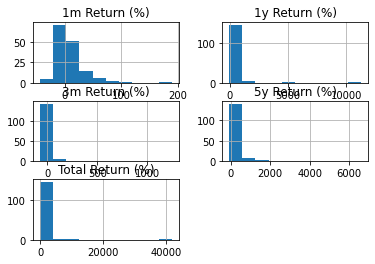

In [149]:
percent_gain_df.hist();

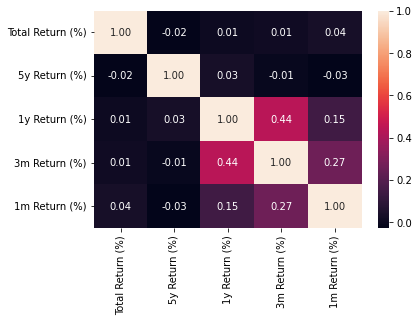

In [153]:
# shows mean reversion and trends are local
sns.heatmap(percent_gain_df.corr(), annot=True, fmt=".2f");

## 1. What companies share price have long-term positive momentum?

In [388]:
# filtering with percent change
# Looking for companies with total return since IPO greater than %342 ( the 75th percentile) and percent loss in the last month less than -%5
percent_filtered_df = percent_gain_df[(percent_gain_df['Total Return (%)']>342) & (percent_gain_df['1m Return (%)']<-5)]
percent_filtered_df = percent_filtered_df.reset_index(drop=True)
percent_filtered_df

,Ticker,Name,Total Return (%),5y Return (%),1y Return (%),3m Return (%),1m Return (%)
0,PDS,Precision Drilling Corporation,1262.87,214.59,10910.53,32.78,37.27
1,CAE,CAE Inc.,466.48,145.80,112.12,-3.18,5.16
2,SJR,Shaw Communications Inc.,1026.05,52.68,92.85,-1.08,1.21
3,IMO,Imperial Oil Limited,2062.75,-29.04,165.36,1.07,29.41
4,WKSP,Worksport Ltd.,800.00,-28.00,4809.09,1048.94,7.78
5,MEOH,Methanex Corporation,683.84,-8.02,261.02,32.73,51.48
6,TRP,TC Energy Corporation,5186.02,43.45,16.96,-1.05,6.66
7,KL,Kirkland Lake Gold Ltd.,699.62,699.62,-0.36,-4.30,5.63
8,SCR,Score Media and Gaming Inc.,1476.02,939.70,1105.19,102.50,5.29
9,NXE,NexGen Energy Ltd.,1139.19,1562.12,250.36,3.40,21.75


## Prepare Data II

Get stock info from Finviz using data filtered by percent change. Clean/ take a subset of the info, selecting the metrics I'm interested in.

Calculate and filter with intrinsic value, and current ratio (current assets/current liabilities), making sure the data is clean and in the right format.

In [675]:
# Get symbols info from finviz html scrapper (len(percent_filtered_df) API calls here)
# using timeit to see how long this takes
start = timeit.timeit()
info_df = pd.DataFrame()
for ticker in percent_filtered_df["Ticker"]:
    if not info_df.empty:
        info_df = info_df.append(get_stock(ticker))
    else:
        info_df = get_stock(ticker)
        
end = timeit.timeit()
print(end - start)
info_df = info_df.reset_index(drop=True)
info_df

-0.014568891987437382


,Ticker,Company,Sector,Industry,Country,Index,P/E,EPS (ttm),Insider Own,Shs Outstand,...,Earnings,Payout,Avg Volume,Price,Recom,SMA20,SMA50,SMA200,Volume,Change
0,PDS,Precision Drilling Corporation,Energy,Oil & Gas Drilling,Canada,-,-,-10.70,1.00%,13.30M,...,Oct 21 BMO,-,42.75K,49.36,1.90,22.38%,39.11%,64.03%,"42,977",2.15%
1,CAE,CAE Inc.,Industrials,Aerospace & Defense,Canada,-,101.00,0.31,1.10%,293.60M,...,Aug 11 BMO,0.00%,242.90K,31.31,2.40,5.88%,6.34%,7.97%,"415,697",1.82%
2,SJR,Shaw Communications Inc.,Communication Services,Telecom Services,Canada,-,20.39,1.44,13.20%,499.00M,...,Oct 29 BMO,89.00%,205.66K,29.34,2.70,0.64%,0.83%,12.72%,"143,392",-0.51%
3,IMO,Imperial Oil Limited,Energy,Oil & Gas Integrated,Canada,-,-,-0.52,72.53%,724.10M,...,Jul 30 BMO,-,416.16K,34.63,3.30,9.95%,20.83%,28.54%,"925,667",1.32%
4,WKSP,Worksport Ltd.,Consumer Cyclical,Auto Parts,Canada,-,-,-0.38,21.80%,9.83M,...,-,-,650.59K,5.93,-,-5.94%,3.62%,-12.35%,"145,998",1.19%
5,MEOH,Methanex Corporation,Basic Materials,Chemicals,Canada,-,38.61,1.26,0.50%,76.21M,...,Oct 27 AMC,11.80%,334.09K,48.69,2.40,2.78%,20.73%,28.02%,"331,511",-2.37%
6,TRP,TC Energy Corporation,Energy,Oil & Gas Midstream,Canada,-,32.36,1.66,0.53%,979.00M,...,Jul 29 BMO,202.60%,1.37M,53.68,1.70,8.71%,10.66%,12.52%,"1,530,167",2.13%
7,KL,Kirkland Lake Gold Ltd.,Basic Materials,Gold,Canada,-,12.01,3.83,4.08%,267.07M,...,Jul 28 AMC,17.90%,1.74M,45.98,-,7.72%,11.60%,16.34%,"1,408,142",-0.80%
8,SCR,Score Media and Gaming Inc.,Communication Services,Electronic Gaming & Multimedia,Canada,-,-,-1.95,24.96%,47.84M,...,Jul 13 AMC,-,1.25M,35.60,-,2.86%,3.70%,44.14%,"657,699",1.31%
9,NXE,NexGen Energy Ltd.,Energy,Uranium,Canada,-,-,-0.42,16.15%,471.86M,...,-,-,2.40M,5.99,-,20.27%,25.32%,46.82%,"2,819,945",-2.44%


In [332]:
# examples of calculating some metrics
float(info_df['Market Cap'][0].strip('M'))*1000000/(float(info_df['Sales'][0].strip('M'))*1000000) # = P/S
# Book value of a company=Total assets−Total liabilities = total equity
float(info_df['Book/sh'][0])*(float(info_df['Shs Outstand'][0].strip('M'))*1000000) # book value

38135000.0

In [434]:
def clean(x):
    """ Clean DataFrame to be used with the panda Series apply() function. Removes M, B and % symbols and converts each cell to float data type"""
    if x[-1] == 'M':
        x = float(x.strip('M'))*1000000
    elif x[-1] == 'B':
        x = float(x.strip('B'))*1000000000
    elif x[-1] == '%':
        x = float(x.strip('%'))/100
    elif x != '-':
        x = float(x)
    return x

In [287]:
info_df.columns

Index(['Company', 'Sector', 'Industry', 'Country', 'Index', 'P/E', 'EPS (ttm)',
       'Insider Own', 'Shs Outstand', 'Perf Week', 'Market Cap', 'Forward P/E',
       'EPS next Y', 'Insider Trans', 'Shs Float', 'Perf Month', 'Income',
       'PEG', 'EPS next Q', 'Inst Own', 'Short Float', 'Perf Quarter', 'Sales',
       'P/S', 'EPS this Y', 'Inst Trans', 'Short Ratio', 'Perf Half Y',
       'Book/sh', 'P/B', 'ROA', 'Target Price', 'Perf Year', 'Cash/sh', 'P/C',
       'EPS next 5Y', 'ROE', '52W Range', 'Perf YTD', 'Dividend', 'P/FCF',
       'EPS past 5Y', 'ROI', '52W High', 'Beta', 'Dividend %', 'Quick Ratio',
       'Sales past 5Y', 'Gross Margin', '52W Low', 'ATR', 'Employees',
       'Current Ratio', 'Sales Q/Q', 'Oper. Margin', 'RSI (14)', 'Volatility',
       'Optionable', 'Debt/Eq', 'EPS Q/Q', 'Profit Margin', 'Rel Volume',
       'Prev Close', 'Shortable', 'LT Debt/Eq', 'Earnings', 'Payout',
       'Avg Volume', 'Price', 'Recom', 'SMA20', 'SMA50', 'SMA200', 'Volume',
       'Ch

In [690]:
# gather interested info and clean / transform data types (relevant info)
cols = ['Company', 'P/E', 'EPS (ttm)', 'Shs Outstand', 'Sales', 'P/S', 'Book/sh', 'P/B', 'ROA', 'Cash/sh', 'Dividend', 'Gross Margin', 'ATR', 'Current Ratio', 'Debt/Eq', 'Price']
rel_info_df = info_df[cols] # rel = relevant
rel_cols = ['P/E', 'EPS (ttm)', 'Shs Outstand', 'Sales', 'P/S', 'Book/sh', 'P/B', 'ROA', 'Cash/sh', 'Dividend', 'Gross Margin', 'ATR', 'Current Ratio', 'Debt/Eq', 'Price']
for col in rel_cols:
    rel_info_df[col] = rel_info_df[col].apply(lambda x: clean(x))
rel_info_df

/Users/philipleblanc/Projects/TradingBot/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price
0,Precision Drilling Corporation,-,-10.70,1.330000e+07,6.504e+08,0.99,77.90,0.63,-0.062,3.93,-,0.304,1.83,1.6,0.94,49.36
1,CAE Inc.,101,0.31,2.936000e+08,2.57e+09,3.79,8.75,3.58,0.014,1.79,-,0.273,0.69,1.3,0.74,31.31
2,Shaw Communications Inc.,20.39,1.44,4.990000e+08,4.43e+09,3.33,9.59,3.06,0.056,0.79,0.96,0.452,0.28,0.8,1.02,29.34
3,Imperial Oil Limited,-,-0.52,7.241000e+08,2.695e+10,1.11,28.68,1.21,-0.01,0.9,0.78,0.199,0.94,1.3,0.25,34.63
4,Worksport Ltd.,-,-0.38,9.830000e+06,400000,167.82,1.28,4.63,-0.416,1.09,-,0.051,0.53,9.0,0.02,5.93
5,Methanex Corporation,38.61,1.26,7.621000e+07,3.48e+09,1.1,18.55,2.62,0.017,9.77,0.5,0.185,1.92,2.1,2.04,48.69
6,TC Energy Corporation,32.36,1.66,9.790000e+08,1.056e+10,4.87,23.56,2.28,0.019,2.61,2.78,0.704,0.93,0.6,1.83,53.68
7,Kirkland Lake Gold Ltd.,12.01,3.83,2.670700e+08,3.14e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98
8,Score Media and Gaming Inc.,-,-1.95,4.784000e+07,2.3e+07,105.31,5.13,6.94,-0.61,-,-,0.131,0.86,11.9,0.09,35.60
9,NexGen Energy Ltd.,-,-0.42,4.718600e+08,-,-,0.93,6.44,-0.378,0.39,-,-,0.40,41.3,0.15,5.99


In [ ]:
# fill missing vals with 0
rel_info_df = rel_info_df.replace('-',0)
rel_info_df

In [679]:
rel_info_df.describe()

,EPS (ttm),Shs Outstand,Book/sh,P/B,ATR,Current Ratio,Debt/Eq,Price
count,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,-0.075000,6.161000e+08,17.441111,3.088889,0.972222,8.272222,0.607778,30.045556
std,3.029483,6.627831e+08,18.166493,2.179719,0.517603,15.500884,0.616580,15.672426
min,-10.700000,9.830000e+06,0.930000,0.630000,0.280000,0.600000,0.000000,4.990000
25%,-0.495000,1.219500e+08,5.250000,1.397500,0.547500,1.050000,0.105000,21.305000
50%,0.085000,3.827300e+08,14.070000,2.450000,0.895000,1.450000,0.500000,30.325000
75%,1.395000,9.152750e+08,23.505000,4.292500,1.357500,7.475000,0.890000,42.507500
max,3.830000,2.020000e+09,77.900000,7.940000,1.920000,56.700000,2.040000,53.680000


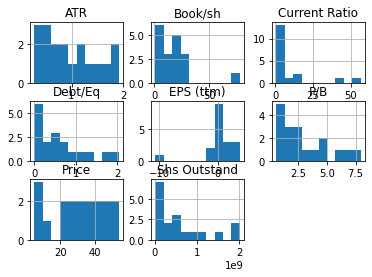

In [680]:
rel_info_df.hist();

## Calculate Intrinsic value

Add relevant info to DataFrame.

In [692]:
# # what companies have the best value?
# intrinsic value
# Intrinsic Value = P/E Ratio X Earnings Per Share

rel_info_df['P/E Intrinsic Value'] = rel_info_df['P/E'] * rel_info_df['EPS (ttm)']
rel_info_df['Undervalued (P/E)'] = rel_info_df['P/E Intrinsic Value']>rel_info_df['Price']

rel_info_df

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E)
0,Precision Drilling Corporation,0.00,-10.70,1.330000e+07,6.504000e+08,0.99,77.90,0.63,-0.062,3.93,0.00,0.304,1.83,1.6,0.94,49.36,-0.0000,False
1,CAE Inc.,101.00,0.31,2.936000e+08,2.570000e+09,3.79,8.75,3.58,0.014,1.79,0.00,0.273,0.69,1.3,0.74,31.31,31.3100,False
2,Shaw Communications Inc.,20.39,1.44,4.990000e+08,4.430000e+09,3.33,9.59,3.06,0.056,0.79,0.96,0.452,0.28,0.8,1.02,29.34,29.3616,True
3,Imperial Oil Limited,0.00,-0.52,7.241000e+08,2.695000e+10,1.11,28.68,1.21,-0.010,0.90,0.78,0.199,0.94,1.3,0.25,34.63,-0.0000,False
4,Worksport Ltd.,0.00,-0.38,9.830000e+06,4.000000e+05,167.82,1.28,4.63,-0.416,1.09,0.00,0.051,0.53,9.0,0.02,5.93,-0.0000,False
5,Methanex Corporation,38.61,1.26,7.621000e+07,3.480000e+09,1.10,18.55,2.62,0.017,9.77,0.50,0.185,1.92,2.1,2.04,48.69,48.6486,False
6,TC Energy Corporation,32.36,1.66,9.790000e+08,1.056000e+10,4.87,23.56,2.28,0.019,2.61,2.78,0.704,0.93,0.6,1.83,53.68,53.7176,True
7,Kirkland Lake Gold Ltd.,12.01,3.83,2.670700e+08,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98,45.9983,True
8,Score Media and Gaming Inc.,0.00,-1.95,4.784000e+07,2.300000e+07,105.31,5.13,6.94,-0.610,0.00,0.00,0.131,0.86,11.9,0.09,35.60,-0.0000,False
9,NexGen Energy Ltd.,0.00,-0.42,4.718600e+08,0.000000e+00,0.00,0.93,6.44,-0.378,0.39,0.00,0.000,0.40,41.3,0.15,5.99,-0.0000,False


Taking the square root of a negative number is NaN therefore I fill NaN with 0 here.

In [ ]:
#  benjamin graham formula intrinsic value calculation
#  Maximum Intrinsic Value = Square root of (15 X 1.5 (Earnings per share) X(Book Value per share))

rel_info_df['BJM Intrinsic Value'] = np.sqrt(15 * 1.5 *rel_info_df['EPS (ttm)'] * rel_info_df['Book/sh'])
rel_info_df['BJM Intrinsic Value'] = rel_info_df['BJM Intrinsic Value'].fillna(0)
rel_info_df['Undervalued (BJM)'] = rel_info_df['BJM Intrinsic Value']>rel_info_df['Price']

rel_info_df.head()

In [ ]:
#  dividend discount model intrinsic value calculation
#  Value of Stock = Dividends per share/(Stockholders rate of return - dividend growth rate)
# rel_info_df['DDM Intrinsic Value'] = rel_info_df['Dividend'] / (1)
# rel_info_df['DDM Intrinsic Value'] = rel_info_df['DDM Intrinsic Value'].fillna(0)
# rel_info_df['Undervalued (DDM)'] = rel_info_df['DDM Intrinsic Value']>rel_info_df['Price']
# rel_info_df


In [694]:
# use current ratio to filter
current_df = rel_info_df[rel_info_df['Current Ratio']>2]
current_df = current_df.reset_index(drop=True)
current_df

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E),BJM Intrinsic Value,Undervalued (BJM)
0,Worksport Ltd.,0.00,-0.38,9830000.0,4.000000e+05,167.82,1.28,4.63,-0.416,1.09,0.00,0.051,0.53,9.0,0.02,5.93,-0.0000,False,0.000000,False
1,Methanex Corporation,38.61,1.26,76210000.0,3.480000e+09,1.10,18.55,2.62,0.017,9.77,0.50,0.185,1.92,2.1,2.04,48.69,48.6486,False,22.932346,False
2,Kirkland Lake Gold Ltd.,12.01,3.83,267070000.0,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.00,45.98,45.9983,True,45.939370,False
3,Score Media and Gaming Inc.,0.00,-1.95,47840000.0,2.300000e+07,105.31,5.13,6.94,-0.610,0.00,0.00,0.131,0.86,11.9,0.09,35.60,-0.0000,False,0.000000,False
4,NexGen Energy Ltd.,0.00,-0.42,471860000.0,0.000000e+00,0.00,0.93,6.44,-0.378,0.39,0.00,0.000,0.40,41.3,0.15,5.99,-0.0000,False,0.000000,False
5,Lithium Americas Corp.,0.00,-0.52,119860000.0,0.000000e+00,0.00,5.61,4.53,-0.092,4.36,0.00,0.000,1.65,56.7,0.29,25.43,-0.0000,False,0.000000,False
6,Aurinia Pharmaceuticals Inc.,0.00,-1.16,128220000.0,5.760000e+07,46.81,2.59,7.94,0.000,2.43,0.00,0.994,1.52,11.9,0.00,20.57,-0.0000,False,0.000000,False
7,Meta Materials Inc.,0.00,-0.38,197910000.0,1.300000e+06,1112.69,1.86,2.68,-0.377,0.53,0.00,0.968,0.42,2.6,0.01,4.99,-0.0000,False,0.000000,False


In [689]:
# find undervalued assets according to intrinsic value calculations
undervalued = rel_info_df[rel_info_df['Undervalued (P/E)'] | rel_info_df['Undervalued (BJM)']]
undervalued

,Company,P/E,EPS (ttm),Shs Outstand,Sales,P/S,Book/sh,P/B,ROA,Cash/sh,Dividend,Gross Margin,ATR,Current Ratio,Debt/Eq,Price,P/E Intrinsic Value,Undervalued (P/E),BJM Intrinsic Value,Undervalued (BJM)
2,Kirkland Lake Gold Ltd.,12.01,3.83,267070000.0,3.140000e+09,4.82,24.49,1.88,0.119,3.23,0.75,0.558,1.41,2.9,0.0,45.98,45.9983,True,45.93937,False


## Create DataFrame of companies with maximum and minimum values for each metric

In [687]:
# find the companies with the max and min of each metric being investigated
columns1=['Company', 'metric', 'max_val']
max_df = pd.DataFrame(columns=columns1)
columns2=['Company', 'metric', 'min_val']
min_df = pd.DataFrame(columns=columns2)

for col, val in dict(undervalued.iloc[:,1:15].max()).items():
    
    max_df = max_df.append(
        pd.Series([undervalued[undervalued[col]==val]['Company'].values[0], 
                   col,
                   val], 
                  index = columns1), 
        ignore_index = True)
    
for col, val in dict(undervalued.iloc[:,1:15].min()).items():

    min_df = min_df.append(
        pd.Series([undervalued[undervalued[col]==val]['Company'].values[0], 
                   col,
                   val], 
                  index = columns2), 
        ignore_index = True)

max_min_df = pd.concat([min_df,max_df], axis=1)

## 2. What companies have the best balance sheet?

In [688]:
max_min_df

,Company,metric,min_val,Company,metric,max_val
0,Kirkland Lake Gold Ltd.,P/E,1.201000e+01,Kirkland Lake Gold Ltd.,P/E,1.201000e+01
1,Kirkland Lake Gold Ltd.,EPS (ttm),3.830000e+00,Kirkland Lake Gold Ltd.,EPS (ttm),3.830000e+00
2,Kirkland Lake Gold Ltd.,Shs Outstand,2.670700e+08,Kirkland Lake Gold Ltd.,Shs Outstand,2.670700e+08
3,Kirkland Lake Gold Ltd.,Sales,3.140000e+09,Kirkland Lake Gold Ltd.,Sales,3.140000e+09
4,Kirkland Lake Gold Ltd.,P/S,4.820000e+00,Kirkland Lake Gold Ltd.,P/S,4.820000e+00
5,Kirkland Lake Gold Ltd.,Book/sh,2.449000e+01,Kirkland Lake Gold Ltd.,Book/sh,2.449000e+01
6,Kirkland Lake Gold Ltd.,P/B,1.880000e+00,Kirkland Lake Gold Ltd.,P/B,1.880000e+00
7,Kirkland Lake Gold Ltd.,ROA,1.190000e-01,Kirkland Lake Gold Ltd.,ROA,1.190000e-01
8,Kirkland Lake Gold Ltd.,Cash/sh,3.230000e+00,Kirkland Lake Gold Ltd.,Cash/sh,3.230000e+00
9,Kirkland Lake Gold Ltd.,Dividend,7.500000e-01,Kirkland Lake Gold Ltd.,Dividend,7.500000e-01


In [589]:
# z and f score info

# https://www.investopedia.com/terms/a/altman.asp
# Altman Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E (likelyhood of bankruptcy)
# A score below 1.8 means it's likely the company is headed for bankruptcy
# Scores above 3 are not likely to go bankrupt

# Where:

# A = working capital / total assets
# B = retained earnings / total assets
# C = earnings before interest and tax / total assets
# D = market value of equity / total liabilities
# E = sales / total assets

# https://www.investopedia.com/terms/p/piotroski-score.asp
# Piotroski F-Score (best value = 9)

# Profitability criteria include:
# Positive net income (1 point)
# Positive return on assets in the current year (1 point)
# Positive operating cash flow in the current year (1 point)
# Cash flow from operations being greater than net Income (quality of earnings) (1 point)

# Leverage, liquidity, and source of funds criteria include:
# Lower ratio of long term debt in the current period, compared to the previous year (decreased leverage) (1 point)
# Higher current ratio this year compared to the previous year (more liquidity) (1 point)
# No new shares were issued in the last year (lack of dilution) (1 point).

# Operating efficiency criteria include:
# A higher gross margin compared to the previous year (1 point)
# A higher asset turnover ratio compared to the previous year (1 point)

## Technical Indicators, Bollinger Bands (BB), Moving Averages (MA's)

Create a plot of company history with MA's, BB's.


In [163]:
# plots
# visualize
# what does the chart show?
def plot_stock(symbol):
    """ Function to plot a stock using it's ticker symbol
    
    params:
    - symbol -> string ticker symbol
    return:
    - matplotlib figure
    """
    
    font1 = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    font2 = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 14,
            }
    
    # calculations
    # typical price
    ticker_history_dict[symbol]['tp'] = (ticker_history_dict[symbol]['High'] + ticker_history_dict[symbol]['Low'] + ticker_history_dict[symbol]['Close']) / 3
    m = 2  # num standard deviations
    # # 20/50/200-day simple moving avg
    ticker_history_dict[symbol]['50dma'] = ticker_history_dict[symbol]['tp'].rolling(50).mean()
    ticker_history_dict[symbol]['200dma'] = ticker_history_dict[symbol]['tp'].rolling(200).mean()
    ticker_history_dict[symbol]['20dma'] = ticker_history_dict[symbol]['tp'].rolling(20).mean()
    # moving standard deviation
    ticker_history_dict[symbol]['stdv'] = ticker_history_dict[symbol]['tp'].rolling(20).std()
    # upper/lower bollinger band
    ticker_history_dict[symbol]['bolu'] = ticker_history_dict[symbol]['20dma'] + (m * ticker_history_dict[symbol]['stdv'])  
    ticker_history_dict[symbol]['bold'] = ticker_history_dict[symbol]['20dma'] - (m * ticker_history_dict[symbol]['stdv'])
    
    # plot 3M with 50 & 200 day moving avg
    threeMonths = ticker_history_dict[symbol].tail(90)
    fig = plt.subplot(311)  # plot max, 1y (with bb), 3m (with ma)
    plt.title("%s Stock Price" % symbol, fontdict=font1)
    # moving avg crossing could be used for signals
    plt.plot(threeMonths.index, threeMonths['Close'].values, 'b-')
    plt.plot(threeMonths.index, threeMonths['200dma'].values, 'r-')  # more bearish
    plt.plot(threeMonths.index, threeMonths['50dma'].values, 'r-')
    plt.plot(threeMonths.index, threeMonths['20dma'].values, 'r-')  # more bullish
    # ax.set_xticks(threeMonths.index[[x for x in range(0,89,89//3)]])
    
    # 1 year with bollinger band
    year = ticker_history_dict[symbol].tail(365)
    fig =plt.subplot(312)
    plt.ylabel('Stock Close Price', fontdict=font2)
    plt.plot(year.index, year['Close'].values, 'b-')
    plt.plot(year.index, year['bolu'].values, 'r-')
    plt.plot(year.index, year['bold'].values, 'r-')
    # ax.set_xticks(year.index[[x for x in range(0, 364, 364//3)]])
    
    # max
    fig = plt.subplot(313)
    plt.plot(ticker_history_dict[symbol].index, ticker_history_dict[symbol]['Close'].values, 'b-')
    plt.xlabel('Date', fontdict=font2)
    # ax.set_xticks(hist.index[[x for x in range(0, len(hist), len(hist)//3)]])
    plt.show()
    return fig

## 3. What does the chart show?

The share price is above the 20-day and 50-day SMA (simple moving average), but below the 200-day SMA for the 3-month period and about constant. The one-year period is about constant and the price is inside the bollinger bands. The overall history is up-trending. 

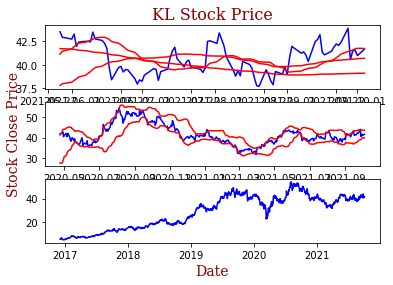

In [695]:
plot_stock('KL')

## Use stock news and analyst recommendations from Finviz 

Use nltk to find sentiment of new news headlines (get_all_news). Predict the next day price using news ticker specific headlines.

In [ ]:
# TODO can use stock news to see if there is a relation to price change
# other useful finviz functions: get analyst target
#example
news = get_all_news()

In [12]:
news

[('11:38PM',
  'Chinese property bonds firm after Kaisa and Sunac make coupon payments',
  'https://www.reuters.com/article/china-evergrande-debt/chinese-property-bonds-firm-after-kaisa-and-sunac-make-coupon-payments-idUSL4N2RF0M0'),
 ('11:35PM',
  'Rent the Runway targets valuation of up to $1.5 billion in IPO',
  'https://www.foxbusiness.com/markets/rent-the-runway-targets-valuation-of-up-to-1-5-billion-in-ipo'),
 ('11:31PM',
  "How Evergrande found itself on the wrong side of China's regulators",
  'https://www.cnbc.com/2021/10/19/how-evergrande-found-itself-on-the-wrong-side-of-chinas-regulators.html'),
 ('11:26PM',
  '‘CoComelon’ owner Moonbug weighs sale, IPO',
  'https://www.foxbusiness.com/markets/cocomelon-owner-moonbug-weighs-sale-ipo'),
 ('11:17PM',
  'China Begins Dollar Bond Sale Even as Evergrande Woes Fester',
  'https://www.bloomberg.com/news/articles/2021-10-19/china-begins-sale-of-four-part-dollar-bond-offering?srnd=markets-vp'),
 ('11:08PM',
  'Nikkei rises on tech b

In [93]:
[s.strip('.to') for s in a.portfolio['Symbol']]

['CGX', 'HUV', 'CNQ', 'L', 'XQB', 'AC', 'WMT', 'XEI', 'VCN', 'GOLD', 'TLRY']

In [117]:
#  FINVIZ doesn't have canadian specific (.to) symbols. Need to check if it is the right company name. 
finviz_news = []
for tick in a.portfolio['Symbol']:
    tick = tick.strip('.to')
    try:
        finviz_news.append(a.get_news(tick))
    except:
        print(f'No results found for "{tick}".')

No results found for "CGX".
No results found for "HUV".
No results found for "XQB".
No results found for "XEI".
No results found for "VCN".


In [130]:
finviz_news[0][:4]

[('2021-11-04 22:32',
  'Canadian Natural Resources Limited (CNQ) Q3 2021 Earnings Call Transcript',
  'https://www.fool.com/earnings/call-transcripts/2021/11/04/canadian-natural-resources-limited-cnq-q3-2021-ear/?source=eptyholnk0000202&utm_source=yahoo-host&utm_medium=feed&utm_campaign=article',
  'Motley Fool'),
 ('2021-11-04 10:45',
  'Canadian Natural Resources (CNQ) Q3 Earnings Beat Estimates',
  'https://finance.yahoo.com/news/canadian-natural-resources-cnq-q3-144502227.html',
  'Zacks'),
 ('2021-11-04 10:02',
  'CANADA STOCKS-Toronto index up on boost from energy, mining shares',
  'https://finance.yahoo.com/news/canada-stocks-toronto-index-boost-140259103.html',
  'Reuters'),
 ('2021-11-04 05:32',
  'Canadian Natural Resources profit beats on higher oil demand, raises dividend',
  'https://finance.yahoo.com/news/canadian-natural-resources-profit-soars-093245300.html',
  'Reuters')]

## Portfolio class

Here I refactor some of the above code from Finviz and Yahoo Finance and load a portfolio of trade history from an excel file. To run you need to have an excel file (default TradeHistory.xls) with data about the portfolio positions when they were made ('Date', 'Position', 'Quantity', 'Symbol', 'SharePrice', 'Value', 'Broker').

In [139]:
# refactor and use a portfolio class
class Portfolio:
    """ 
    Class to analyze a watchlist of positions. Uses yfinance and Finviz opensource unofficial API's.
    
    Collects data for watchlist of stocks and loads data from csv.
    
    Pretty large class. Could inherit Finviz or yfinance? Just need to watch for changes to the website and github
    """
    
    #  FINVIZ URLS
    STOCK_URL = "https://finviz.com/quote.ashx"
    NEWS_URL = "https://finviz.com/news.ashx"
    CRYPTO_URL = "https://finviz.com/crypto_performance.ashx"
    STOCK_PAGE = {}
    
    def __init__(self, filename='TradeHistory.xls'):
        """ Initialize with xls file of trade history"""
        # example portfolio
        self.portfolio_history = pd.read_excel(filename, index_col=None) 
        self.master_watchlist_set = {'infn', 'iyw', 'net', 'amd', 'fts.to', 'mgi', 'dis', 'omg', 
                                     'bynd', 'pll', 'mu', 'vwagy', 'smh', 'msft', 'qqq', 'subz', 'zwb.to', 'disca', 
                                     'anf', 'slv', 'food', 'fubo', 'f', 'crox', 'ada', 'goro', 'potx', 'copx', 
                                     'tlt.to', 'su.to', 'bke', 'snoa', 'gld', 'de.to', 'sprt', 'mara', 
                                     'btc-cad', 'lumn', '^dji', 'aapl', 'kss', 'ag', 'fcx', 'pfe', 
                                     'xme', 'mj', 'ac.to', 'fcel', 'sono', 'mchp', 'love', 'intc', 'amzn', 
                                     'ar', 'viac', 'dia', 'jwn', 'cat', 'fru.to', 'grwg', 'dash', 'hwx.to', 
                                     'doge-cad', 'xbm', 'spy', 'pslv', 'm', 'uvxy', 'fb', 'mcd', 'tsla', 'nvda', 
                                     'xpev', 'qcom', 'crm', 'googl', 'nflx'}
        
        # CALL UNOFFICIAL YAHOO FINANCE API
        self.ticker_history_dict = {}
        self.yf_ticker_dict = {}  # storing yahoo finance API code ticker objs
        # get history for open trades
        for symbol in self.portfolio.Symbol.unique():
            self.yf_ticker_dict[symbol] = yf.Ticker(symbol)
            self.ticker_history_dict[symbol] = self.yf_ticker_dict[symbol].history(period = "max")
        # get history for watchlist
        for symbol in self.master_watchlist_set:
            self.yf_ticker_dict[symbol] = yf.Ticker(symbol)
            self.ticker_history_dict[symbol] = self.yf_ticker_dict[symbol].history(period = "max")
        
        # call calculate gain/loss function defined below
        self.total_gl = 0 # total gain/loss initialized to 0
        self.calculate_gl()
        
        
        self.portfolio_size = self.portfolio['Value'].sum()
        self.total_gl = 0  # find current gain/loss (set using calculate_gl() )
        self.cash = 6000

    def get_tickers(self):
        """return a pd.Series object"""
        return self.portfolio['Symbol']
    
    def add_position(self, position, entry, ):
        """ Append to dataframe"""
        #self.positions_df = self.positions_df.append(pd.DataFrame(pos))
        pass
    
    def add_to_watchlist(self, ticker ):
        """ Append to watchlist and get historic data"""
        self.master_watchlist_set.add(ticker)
        self.yf_ticker_dict[ticker] = yf.Ticker(ticker)
        self.ticker_history_dict[ticker] = self.yf_ticker_dict[ticker].history(period = "max")
    
    def remove_position(self, position):
        """ Drop row from dataframe"""
#         self.positions_df = self.positions_df.drop()
        pass

    def calculate_gl(self):
        """Calculate gain/loss for shares held"""
        self.portfolio['Previous Close'] = [self.ticker_history_dict[symbol].tail(1).Close.values[0] for symbol in self.portfolio.Symbols]
        self.portfolio['G/L'] = self.portfolio['Quantity'] * self.portfolio['Previous Close'] - self.portfolio['Value']
        self.portfolio['G/L %'] = self.portfolio['G/L'] / self.portfolio['Value'] * 100
        self.total_gl = self.portfolio['G/L'].sum()
        
    
    def calculate_stop(self):
        """set stop based on volatility. Ideally should not loose more than 5%"""
        pass
    
    def calculate_target(self):
        """set target to 2-4X"""
        pass
    
    def save_excel():
        """Save open position analysis to excel (G/L calculation)"""
        self.portfolio.to_excel('analysis.xls')
        
    def valuation_rank():
        """Valuation based ranking"""
        pass
    
    def priceIndicator():
        """Calculate a prediction of stock price for master_watchlist_set based on historic data"""
        pass
    
    def LSTMmodel(x_train, y_train, epochs=1, bach_size=1)
    
    """NOTE: CODE below from unofficial FINVIZ API and not my own."""
    
    def get_page(self, ticker):
        global STOCK_PAGE

        if ticker not in STOCK_PAGE:
            STOCK_PAGE[ticker], _ = http_request_get(
                url=STOCK_URL, payload={"t": ticker}, parse=True
            )
    
    def get_stock(self, ticker):
        """
        Returns a pandas dataframe containing stock data.
        :param ticker: stock symbol
        :type ticker: str
        :return dataframe
        """

        get_page(ticker)
        page_parsed = STOCK_PAGE[ticker]

        title = page_parsed.cssselect('table[class="fullview-title"]')[0]
        keys = ["Ticker", "Company", "Sector", "Industry", "Country"]
        fields = [ticker]+[f.text_content() for f in title.cssselect('a[class="tab-link"]')]
        data = dict(zip(keys, fields))

        all_rows = [
            row.xpath("td//text()")
            for row in page_parsed.cssselect('tr[class="table-dark-row"]')
        ]

        for row in all_rows:
            for column in range(0, 11, 2):
                data[row[column]] = row[column + 1]

        return pd.DataFrame.from_dict(data, orient='index').transpose()


    def get_news(self, ticker):
        """
        Returns a list of sets containing news headline and url
        :param ticker: stock symbol
        :return: list
        """

        get_page(ticker)
        page_parsed = STOCK_PAGE[ticker]
        rows = page_parsed.cssselect('table[id="news-table"]')[0].xpath('./tr[not(@id)]')

        results = []
        date = None
        for row in rows:
            raw_timestamp = row.xpath("./td")[0].xpath('text()')[0][0:-2]

            if len(raw_timestamp) > 8:
                parsed_timestamp = datetime.strptime(raw_timestamp, "%b-%d-%y %I:%M%p")
                date = parsed_timestamp.date()
            else:
                parsed_timestamp = datetime.strptime(raw_timestamp, "%I:%M%p").replace(
                    year=date.year, month=date.month, day=date.day)

            results.append((
                parsed_timestamp.strftime("%Y-%m-%d %H:%M"),
                row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].xpath("text()")[0],
                row.xpath("./td")[1].cssselect('a[class="tab-link-news"]')[0].get("href"),
                row.xpath("./td")[1].cssselect('div[class="news-link-right"] span')[0].xpath("text()")[0][1:]
            ))

        return results

    def get_insider(self, ticker):
        """
        Returns a list of dictionaries containing all recent insider transactions.
        :param ticker: stock symbol
        :return: list
        """

        get_page(ticker)
        page_parsed = STOCK_PAGE[ticker]
        table = page_parsed.cssselect('table[class="body-table"]')[0]
        headers = table[0].xpath("td//text()")
        data = [dict(zip(headers, row.xpath("td//text()"))) for row in table[1:]]

        return data

    def get_all_news(self):
        """
        Returns a list of sets containing time, headline and url
        :return: list
        """

        page_parsed, _ = http_request_get(url=NEWS_URL, parse=True)
        all_dates = [
            row.text_content() for row in page_parsed.cssselect('td[class="nn-date"]')
        ]
        all_headlines = [
            row.text_content() for row in page_parsed.cssselect('a[class="nn-tab-link"]')
        ]
        all_links = [
            row.get("href") for row in page_parsed.cssselect('a[class="nn-tab-link"]')
        ]

        return list(zip(all_dates, all_headlines, all_links))


    def get_crypto(self, pair):
        """
        :param pair: crypto pair
        :return: dictionary
        """

        page_parsed, _ = http_request_get(url=CRYPTO_URL, parse=True)
        page_html, _ = http_request_get(url=CRYPTO_URL, parse=False)
        crypto_headers = page_parsed.cssselect('tr[valign="middle"]')[0].xpath("td//text()")
        crypto_table_data = get_table(page_html, crypto_headers)

        return crypto_table_data[pair]


    def get_analyst_price_targets(self, ticker, last_ratings=5):
        """
        Returns a list of dictionaries containing all analyst ratings and Price targets
         - if any of 'price_from' or 'price_to' are not available in the DATA, then those values are set to default 0
        :param ticker: stock symbol
        :param last_ratings: most recent ratings to pull
        :return: list
        """

        analyst_price_targets = []

        try:
            get_page(ticker)
            page_parsed = STOCK_PAGE[ticker]
            table = page_parsed.cssselect('table[class="fullview-ratings-outer"]')[0]

            for row in table:
                rating = row.xpath("td//text()")
                rating = [val.replace("→", "->").replace("$", "") for val in rating if val != '\n']
                rating[0] = datetime.strptime(rating[0], "%b-%d-%y").strftime("%Y-%m-%d")

                data = {
                    "date":     rating[0],
                    "category": rating[1],
                    "analyst":  rating[2],
                    "rating":   rating[3],
                }
                if len(rating) == 5:
                    if "->" in rating[4]:
                        rating.extend(rating[4].replace(" ", "").split("->"))
                        del rating[4]
                        data["target_from"] = float(rating[4])
                        data["target_to"] = float(rating[5])
                    else:
                        data["target"] = float(rating[4])

                analyst_price_targets.append(data)
        except Exception as e:
            # print("-> Exception: %s parsing analysts' ratings for ticker %s" % (str(e), ticker))
            pass

        return analyst_price_targets[:last_ratings]
        

In [140]:
p = Portfolio()

In [212]:
p.symbol_history_dict.keys()

dict_keys(['CGX.to', 'HUV.to', 'CNQ.to', 'L.to', 'XQB.to', 'AC.to', 'WMT', 'XEI.to', 'VCN.to', 'GOLD.to', 'TLRY.to'])

In [217]:
p.portfolio.columns

Index(['Date', 'Position', 'Quantity', 'Symbol', 'SharePrice', 'Value',
       'Broker', 'Previous Close', 'G/L'],
      dtype='object')

In [215]:
print(p.master_watchlist_set)

{'iyw', 'mu', 'qqq', 'copx', 'tlt.to', 'bke', 'viac', 'hwx.to', 'xbm', 'fb', 'tsla', 'infn', 'net', 'fts.to', 'mgi', 'bynd', 'xqb.to', 'pll', 'smh', 'zwb.to', 'ada', 'sprt', 'btc-cad', 'aapl', 'vcn.to', 'mchp', 'ar', 'dia', 'cat', 'fru.to', 'dash', 'm', 'mcd', 'gold.to', 'amd', 'msft', 'vwagy', 'disca', 'anf', 'slv', 'food', 'fubo', 'goro', 'snoa', 'gld', 'de.to', 'lumn', 'kss', 'ag', 'fcx', 'pfe', 'ac.to', 'sono', 'love', 'intc', 'amzn', 'grwg', 'spy', 'wmt', 'dis', 'subz', 'huv.to', 'f', 'crox', 'potx', 'tlry.to', 'su.to', 'mara', '^dji', 'omg', 'xme', 'mj', 'fcel', 'jwn', 'pslv', 'uvxy', 'doge-cad'}


In [211]:
p.calculate_gl()

,Date,Position,Quantity,Symbol,SharePrice,Value,Broker,Previous Close,G/L
0,2019-12-20,BUY,25,CGX.to,33.95,848.75,Scotia iTrade,14.860000,-477.250009
1,2020-03-23,BUY,2,HUV.to,149.81,299.62,Scotia iTrade,9.370000,-280.880000
2,2020-05-01,BUY,52,CNQ.to,24.23,1259.96,Scotia iTrade,52.000000,1444.040000
3,2020-06-30,BUY,13,L.to,66.37,862.81,Scotia iTrade,98.070000,412.099996
4,2019-06-06,BUY,69,XQB.to,21.07,1453.83,Qtrade,20.670000,-27.599995
5,2020-06-11,BUY,55,AC.to,22.28,1225.40,Qtrade,25.250000,163.350000
6,2020-07-01,BUY,8,WMT,118.26,946.08,Qtrade,147.759995,235.999956
7,2020-07-08,BUY,100,XEI.to,16.95,1695.00,Questrade,25.230000,827.999954
8,2020-07-27,BUY,10,VCN.to,32.50,325.00,Questrade,43.939999,114.399986
9,2020-07-27,BUY,100,GOLD.to,2.32,232.00,Questrade,2.020000,-30.000002


# Simple stock price indicator

Sources:
        - https://www.youtube.com/watch?v=QIUxPv5PJOY&ab_channel=ComputerScience,
        - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

I wanted to try the Long Short-Term Memory (LSTM) neural network from Keras I saw used in the youtube video and read about above. Jason Brownlee is a phd and has a lot of good reading material. The LSTM is ideal for this case since it resembles a regression problem. Even with minimal model layers and training it performs effectively for the case I test with. The following code can be refactored and used in the portfolio class above.

In [157]:
# change plot style
plt.style.use('fivethirtyeight')

In [213]:
ticker_history_dict.keys()

dict_keys(['SCR', 'PCOM', 'MIST', 'NOA', 'FUSN', 'GAME', 'DRTT', 'PROF', 'CIXX', 'PDS', 'THTX', 'VS', 'CGAU', 'ACHV', 'IPA', 'BRAG', 'LOOP', 'GP', 'ABST', 'MDVL', 'VEV', 'EPIX', 'NMG', 'EMX', 'SWIR', 'WKSP', 'PYR', 'VQS', 'MMX', 'LMNL', 'SII', 'TIXT', 'CAE', 'ELYS', 'NEWP', 'TMQ', 'LGO', 'RPTX', 'DPRO', 'CLS', 'ORLA', 'BEP', 'GSS', 'EGLX', 'ATY', 'IMV', 'FTRP', 'RCI', 'SJR', 'APT', 'TAC', 'TNK', 'YVR', 'HITI', 'GAU', 'MTA', 'IMO', 'MERC', 'DTEA', 'GROY', 'TRIL', 'OR', 'MEOH', 'AAU', 'RFP', 'FTS', 'SA', 'MAG', 'VFF', 'GOOS', 'GIL', 'PVG', 'XENE', 'TRX', 'HUGE', 'CSIQ', 'PBA', 'BLU', 'AXU', 'NG', 'PLG', 'LEV', 'SILV', 'ABCL', 'TRQ', 'LICY', 'BHC', 'WPRT', 'SSRM', 'TU', 'AQN', 'SAND', 'EGO', 'IMAX', 'HBM', 'ZYME', 'KL', 'NEPT', 'SVM', 'TGB', 'ERF', 'EQX', 'SOLO', 'SLI', 'GFL', 'WPM', 'AGI', 'CNQ', 'PAAS', 'MOGO', 'VET', 'MUX', 'APTO', 'NXE', 'TMC', 'UROY', 'GPL', 'LAC', 'CPG', 'MFC', 'CRON', 'BLDP', 'FSM', 'GTE', 'EXK', 'AUPH', 'AG', 'MMAT', 'ENB', 'NGD', 'NAK', 'TECK', 'CCJ', 'ACB', 'OGI

In [257]:
def LSTM_train_test_split(data=data, scaler=scaler, ratio=0.8, numdays=60):
    """
    Series to supervised.
    
    Input:
    :param data: stock symbol close price dataframe
    :param ratio: decimal percentage of data to use for training. Default: 0.8
    :param numdays: number of days to use to predict following day
    Output:
    :x_train: numpy arrays
    :y_train: numpy arrays
    :x_test: numpy arrays
    :y_test: numpy arrays
    """
    # numpy array
    dataset = data.values
    # use 80% of rows to train
    train_len = math.ceil(len(dataset) * ratio)
    # Scale data with minmaxscaler
    scaled_data = scaler.fit_transform(dataset)
    
    # get the scaled training dataset
    train_data = scaled_data[:train_len]
    # split into x and y train
    x_train = []
    y_train = []
    # numdays represents the number of days in the past to use in the model to predict the following day
    # this for loop creates a list of arrays (x_train) of numdays values (previous stock close price)
    # and a list of floats (y_train) which is the price the day after
    for i in range(numdays, train_len):
        x_train.append(train_data[i-numdays:i,0])
        y_train.append(train_data[i,0])

    # get the scaled testing dataset
    test_data = scaled_data[train_len-numdays:]
    # split into x and y train
    x_test = []
    # y_test is a numpy array of close price after the training values length
    y_test = dataset[train_len:]
    # x_test is a list of arrays of numdays values (previous stock close price)
    for i in range(numdays, len(test_data)):
        x_test.append(test_data[i-numdays:i,0])
        
    # convert training set to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    # reshape
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # convert testing set to numpy arrays
    x_test = np.array(x_test)
    # reshape
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test

In [241]:
def LSTM_model(input_shape):
    """
    Build the LSTM model with Keras tensorflow.
    """
    # Build LSTM model (when refactoring the following two cells only need to be done once)
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape = input_shape))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))
    # compile the model choosing optimizer and loss function 
    model.compile(optimizer='adam',loss='mean_squared_error')
    return model

In [266]:
def LSTM_test(model, x_test, y_test, data=data, scaler=scaler):
    # Get models prediction
    predictions = model.predict(x_test) # predict closing 
    predictions = scaler.inverse_transform(predictions)
    # get root mean squared error (rmse)
    rmse = np.sqrt(np.mean(((predictions - y_test)**2))) # [:(len(predictions)-60)]
    
    # plot predictions
    train_len = len(data)-len(x_test)
    train = data[:train_len]
    valid = data[train_len:]
    valid['Predictions'] = predictions
    # visual
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price (USD $)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
#     plt.plot(predictions)
    plt.legend(['Train', 'Val', 'Predictions'])
    plt.show()
    
    return rmse

In [ ]:
# dataset = dataset.reshape(1,-1) # reshape to 2d array
data = ticker_history_dict['BB'].filter(['Close'])

In [243]:
data.describe() 

,Close
count,5716.000000
mean,23.019254
std,27.635490
min,1.270833
25%,7.107500
50%,10.360000
75%,25.460833
max,147.550003


In [261]:
len(x_test), len(y_test)

(1143, 1143)

4513/4513 [==============================] - 177s 38ms/step - loss: 9.8660e-04


/Users/philipleblanc/Projects/TradingBot/stocks/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


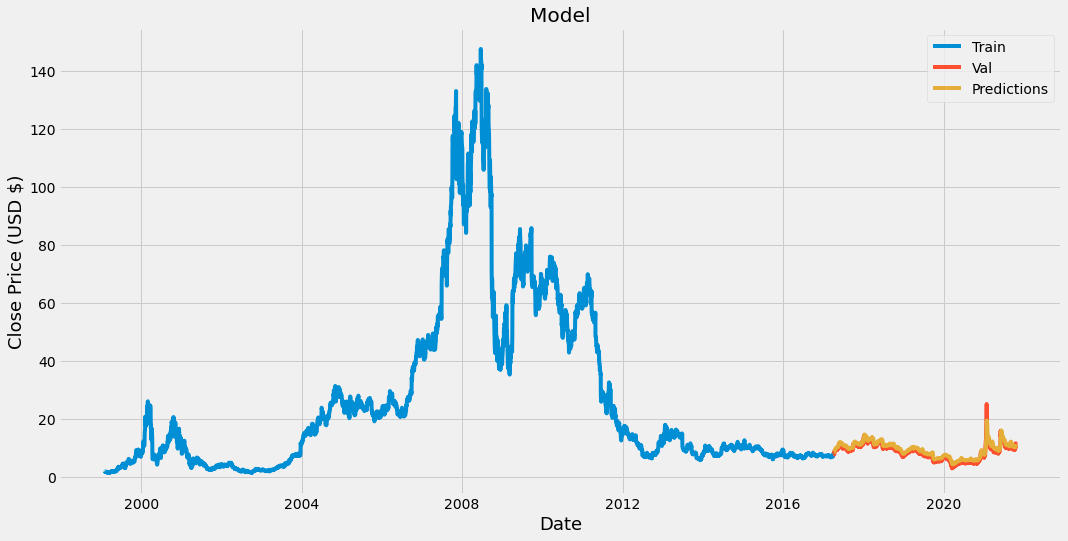

In [267]:
scaler = MinMaxScaler() # feature_range = (0,1)
x_train, y_train, x_test, y_test = LSTM_train_test_split(data=data, scaler=scaler, ratio=0.8, numdays=60)
model = LSTM_model((x_train.shape[1], 1))
# fit the model with the training data (this will need to be done for each symbol with data preparation)
model.fit(x_train, y_train, batch_size=1, epochs=1)
rmse = LSTM_test(model, x_test, y_test, data=data, scaler=scaler)

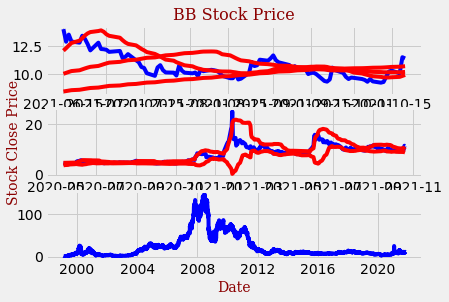

In [238]:
plot_stock('BB')